In [8]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import uniform
from qadence import *

import torch
from torch import nn, optim, tensor, zeros_like, ones_like, linspace, manual_seed
from torch.autograd import grad

from typing import Union

In [9]:
manual_seed(42) #  random seed
N_QUBITS, DEPTH, LEARNING_RATE, N_POINTS = 6, 5, 0.01, 20 

In [10]:
ansatz = hea(n_qubits=N_QUBITS, depth=DEPTH, operations=[RZ, RX, RZ])

In [13]:
def standard(i : int) -> Union[int, float]:
    return 2

def tower(i : int) -> Union[int, float]: #MAYBE ANOTHER PYTHON VERSION - NOT LATEST FOR QADENCE!!
    return 2*i

cheb = feature_map(n_qubits=N_QUBITS, param="x", fm_type = BasisSet.CHEBYSHEV, op = RY, reupload_scaling = standard)#, feature_range = (0,0.9), target_range = (-0.99,0.99))
chebT = feature_map(n_qubits=N_QUBITS, param="x", fm_type = BasisSet.CHEBYSHEV, op = RY, reupload_scaling = tower)

fm = chebT

In [14]:
obs = hamiltonian_factory(N_QUBITS, detuning = Z)
#obs = ising_hamiltonian(n_qubits=N_QUBITS)

In [19]:
circuit = QuantumCircuit(N_QUBITS, chain(fm, ansatz))
model = QNN(circuit=circuit, observable=obs, inputs=["x"])

In [20]:
opt = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
#Define analytical solution for regularized ODE
def u(x):
    return torch.exp(-8*0.1*x)*torch.cos(8*x)

In [22]:
#criterion = nn.functional.mse_loss

def loss_fn(inputs: tensor, outputs: tensor) -> tensor:
    
    boundary_loss = -(model(zeros_like(inputs)) - 1*ones_like(inputs)) 
    dfdx = grad(inputs=inputs, outputs=outputs.sum(), create_graph=True)[0]
    f = 8*outputs*(0.1+torch.tan(8*inputs))

    ode_loss = (dfdx+f).pow(2)
    boundary_loss = (1*ones_like(inputs) - model(zeros_like(inputs))).pow(2)

    return ode_loss.mean() + 50*boundary_loss.mean()

In [27]:
for epoch in range(1000):
    opt.zero_grad()

    cp = linspace(0.0, 0.9, N_POINTS, requires_grad=True)
    cp = torch.reshape(cp, (N_POINTS,1))

    loss = loss_fn(inputs=cp, outputs=model(cp))
    
    if (epoch % 50 == 0):
        print(epoch, loss.item())
        
    loss.backward()
    opt.step()

0 0.35784394716968604
50 0.2815805544542414
100 0.22114136311516558
150 0.1733621533080062
200 0.13631347700611854
250 0.1080210721614816
300 0.08648509431946891
350 0.06999323426022686
400 0.05723100628873017
450 0.04723708620832047
500 0.03931959578083048
550 0.03298100252397679
600 0.027860838583203654
650 0.023694398757469287
700 0.020283826967112752
750 0.01747830396620815
800 0.015160660658965134
850 0.013238677133410853
900 0.012025887681919055
950 0.010627127710419565


In [31]:
sample_points = linspace(0.0, 0.9, steps=100).reshape(-1, 1)
analytic_sol = torch.exp(-0.1*8*sample_points)*torch.cos(8*sample_points) 

In [32]:
dqc_sol = model(sample_points).detach().numpy()
x_data = sample_points.detach().numpy()

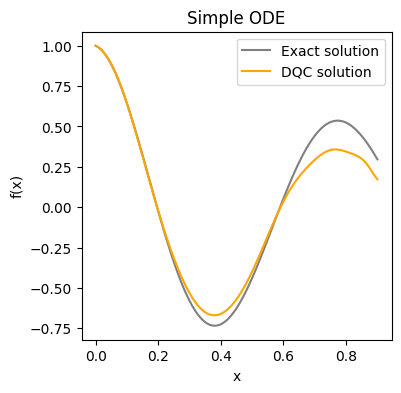

In [33]:
plt.figure(figsize=(4, 4))
plt.plot(x_data, analytic_sol.flatten(), color="gray", label="Exact solution")
plt.plot(x_data, dqc_sol.flatten(), color="orange", label="DQC solution")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Simple ODE")
plt.legend()
plt.show()